# Time Series with the Prophet Module

This notebook uses hourly energy demand data from ERCOT in Texas to predict future demand. This version uses data from multiple years.

In [ ]:
! pip install -r requirements.txt

In [1]:
import pandas as pd
from fbprophet import Prophet

%matplotlib inline

In [10]:
df = pd.read_excel("data/Native_Load.xlsx")

In [11]:
df.head()

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT,time,d,date
0,01/01/2018 01:00,11425.979115,1852.663959,2823.409245,1135.360907,18584.343617,3831.649454,9151.190703,1762.472684,50567.069682,2018-01-01 00:00:00,2018-01-01 01:00:00,01/01/2018 00:00:00
1,01/01/2018 02:00,11408.418023,1850.169452,2809.745403,1136.630855,18524.141392,3988.271046,9144.993712,1754.718094,50617.087977,2018-01-01 01:00:00,2018-01-01 02:00:00,01/01/2018 01:00:00
2,01/01/2018 03:00,11405.198365,1858.269586,2797.802576,1135.930264,18532.056616,4076.086451,9141.036615,1747.919615,50694.300087,2018-01-01 02:00:00,2018-01-01 03:00:00,01/01/2018 02:00:00
3,01/01/2018 04:00,11450.560138,1879.623596,2807.793880,1146.069491,18647.444612,4154.939804,9157.956866,1755.203307,50999.591693,2018-01-01 03:00:00,2018-01-01 04:00:00,01/01/2018 03:00:00
4,01/01/2018 05:00,11631.337459,1876.481320,2822.989206,1154.186967,19002.102222,4247.451523,9214.333628,1774.849690,51723.732017,2018-01-01 04:00:00,2018-01-01 05:00:00,01/01/2018 04:00:00


In [12]:
df["ERCOT"].dtype

dtype('float64')

In [13]:
df["date"] = pd.to_datetime(df["date"])

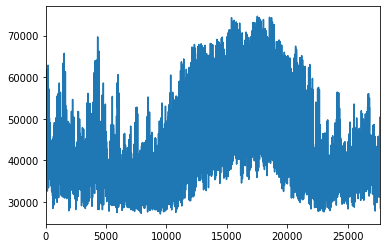

In [14]:
df["ERCOT"].plot()

In [19]:
df.set_index("date", inplace=True)

In [27]:
df1 = df[["date", "ERCOT"]]

In [30]:


df1.columns = ["ds", "y"]

m = Prophet()
m.fit(df1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [31]:
future = m.make_future_dataframe(periods=12)
future.tail()

,ds
1423,2021-03-09 23:00:00
1424,2021-03-10 23:00:00
1425,2021-03-11 23:00:00
1426,2021-03-12 23:00:00
1427,2021-03-13 23:00:00


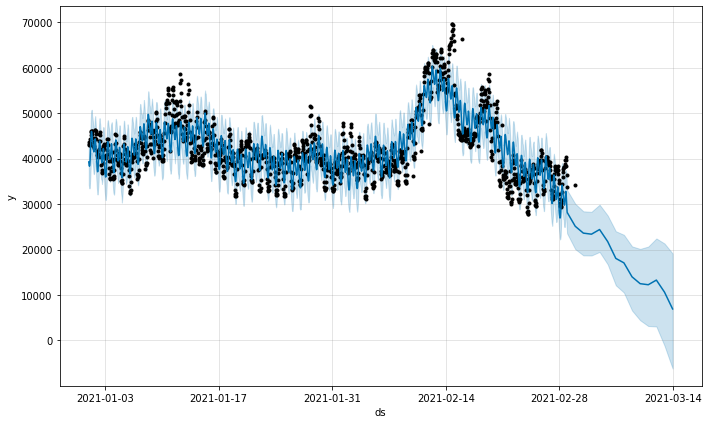

In [34]:
future = m.make_future_dataframe(periods=12, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)

In [29]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
55,2020-08-01,58.669687,-177.634158,256.079276
56,2020-09-01,-4.959560,-232.997605,211.991656
57,2020-10-01,162.887977,-37.343159,400.501144
58,2020-11-01,151.120375,-70.291781,363.937440
59,2020-12-01,183.928233,-37.965777,396.521646


In [49]:
import plotly.graph_objs as go

def timeseries(df, x, yhat, lower, upper, actual, save = False):

    fig = go.Figure([
        go.Scatter(
            name='Measurement',
            x=df[x],
            y=df['yhat'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
            showlegend=False
        ),
        go.Scatter(
            name='Upper Bound',
            x=df[x],
            y=df[upper],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=df[x],
            y=df[lower],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
    fig.update_layout(
        yaxis_title='Production Rate',
        title='Unemployment rate estimate using Prophet Forecast',
        hovermode="x"
    )
    fig.add_trace(go.Scatter(x=actual['ds'], y=actual["y"],
                    mode='lines+markers',
                    name='Actual values',
                    showlegend=False))
  
    fig.add_trace(go.Scatter(x=df[x], y=df["curve"],
                    mode='lines+markers',
                    name='Actual values',
                    showlegend=False))   
    
    fig.show()
    
    if save: 
        fig.write_html("unemployment rate.html")

In [50]:
timeseries(forecast,'ds', 'yhat', 'yhat_lower', 'yhat_upper', actual = df1, save = True)

In [18]:
# Import pandas (DataFrames), SciPy (optimization functions), and matplotlib (plotting).
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

# Creating some functions we can use to calcuate the hyperbolic curve and initial max production level
def hyperbolic_equation(t, qi, b, di):
    return qi/((1.0+b*di*t)**(1.0/b)) 

def get_max_initial_production(df, number_first_months, variable_column, date_column):
    df=df.sort_values(by=date_column)
    df_beginning_production=df.head(number_first_months)
    return df_beginning_production[variable_column].max()


In [32]:
df.head()

,Unnamed: 0,ReportDate,API_WELLNO,FileNo,Company,WellName,Quarter,Section,Township,Range,...,Pool,Oil,Wtr,Days,Runs,Gas,GasSold,Flared,Lat,Long
0,411673,2016-01-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,BAKKEN,1334,1080,31,1347,1129,917,150,47.820239,-104.005077
1,364481,2016-02-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,BAKKEN,1144,1096,29,1069,2396,2215,123,47.820239,-104.005077
2,209403,2016-03-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,BAKKEN,1101,1202,31,1229,2196,1803,331,47.820239,-104.005077
3,115337,2016-04-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,BAKKEN,1096,955,30,1009,1832,1446,326,47.820239,-104.005077
4,85217,2016-05-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,BAKKEN,1054,885,31,1083,1973,1664,247,47.820239,-104.005077


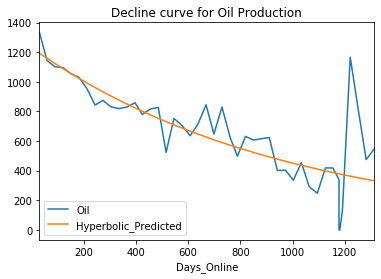

In [41]:

# Reading the data into Python and saving it as a Pandas DataFrame
desired_product_type='Oil' # or 'Gas'
    


# Evaluating the decline curve and saving it as a column in the DataFrame called "Hyperbolic Predicted"
qi=get_max_initial_production(df, 5, desired_product_type, 'ReportDate')
popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, df['Days_Online'], 
                                    df[desired_product_type],bounds=(0, [qi,2,20]))
df.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(df['Days_Online'], *popt_hyp)

# Plotting the actual and predicted production values
df.plot(x='Days_Online', y=[desired_product_type, "Hyperbolic_Predicted"], 
                                    title=f"Decline curve for {desired_product_type} Production")

In [45]:
forecast["curve"] = df['Hyperbolic_Predicted']

In [39]:
df.head()

,Unnamed: 0,ReportDate,API_WELLNO,FileNo,Company,WellName,Quarter,Section,Township,Range,...,Oil,Wtr,Days,Runs,Gas,GasSold,Flared,Lat,Long,Hyperbolic_Predicted
0,411673,2016-01-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,1334,1080,31,1347,1129,917,150,47.820239,-104.005077,643.645697
1,364481,2016-02-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,1144,1096,29,1069,2396,2215,123,47.820239,-104.005077,643.645697
2,209403,2016-03-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,1101,1202,31,1229,2196,1803,331,47.820239,-104.005077,643.645697
3,115337,2016-04-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,1096,955,30,1009,1832,1446,326,47.820239,-104.005077,643.645697
4,85217,2016-05-01,33053000000000,23537,WHITING OIL AND GAS CORPORATION,AMBER ELIZABETH 9-4H,SESW,9,150,104,...,1054,885,31,1083,1973,1664,247,47.820239,-104.005077,643.645697


In [40]:
df['Days_Online'] = df["Days"].cumsum()

In [48]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,curve
0,2016-01-01,1090.563692,881.932874,1341.509116,1090.563692,1090.563692,35.227149,35.227149,35.227149,35.227149,35.227149,35.227149,0.0,0.0,0.0,1125.790841,1193.706569
1,2016-02-01,1072.661302,888.422557,1332.807520,1072.661302,1072.661302,27.486489,27.486489,27.486489,27.486489,27.486489,27.486489,0.0,0.0,0.0,1100.147791,1158.990071
2,2016-03-01,1055.913905,775.969051,1203.196129,1055.913905,1055.913905,-63.253405,-63.253405,-63.253405,-63.253405,-63.253405,-63.253405,0.0,0.0,0.0,992.660500,1123.029294
3,2016-04-01,1038.011515,776.386078,1226.585050,1038.011515,1038.011515,-46.684550,-46.684550,-46.684550,-46.684550,-46.684550,-46.684550,0.0,0.0,0.0,991.326965,1089.323852
4,2016-05-01,1020.686621,608.976714,1034.873224,1020.686621,1020.686621,-191.998647,-191.998647,-191.998647,-191.998647,-191.998647,-191.998647,0.0,0.0,0.0,828.687974,1055.589842
5,2016-06-01,1002.784231,717.884405,1166.270944,1002.784231,1002.784231,-58.069818,-58.069818,-58.069818,-58.069818,-58.069818,-58.069818,0.0,0.0,0.0,944.714414,1023.969532
6,2016-07-01,985.459338,695.146488,1142.456140,985.459338,985.459338,-54.813245,-54.813245,-54.813245,-54.813245,-54.813245,-54.813245,0.0,0.0,0.0,930.646092,992.320444
7,2016-08-01,967.556948,682.709330,1118.720399,967.556948,967.556948,-65.198878,-65.198878,-65.198878,-65.198878,-65.198878,-65.198878,0.0,0.0,0.0,902.358069,961.679547
8,2016-09-01,949.654558,619.869536,1073.865935,949.654558,949.654558,-110.927260,-110.927260,-110.927260,-110.927260,-110.927260,-110.927260,0.0,0.0,0.0,838.727297,932.955843
9,2016-10-01,932.329664,782.102510,1238.416738,932.329664,932.329664,74.243696,74.243696,74.243696,74.243696,74.243696,74.243696,0.0,0.0,0.0,1006.573360,904.203300


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

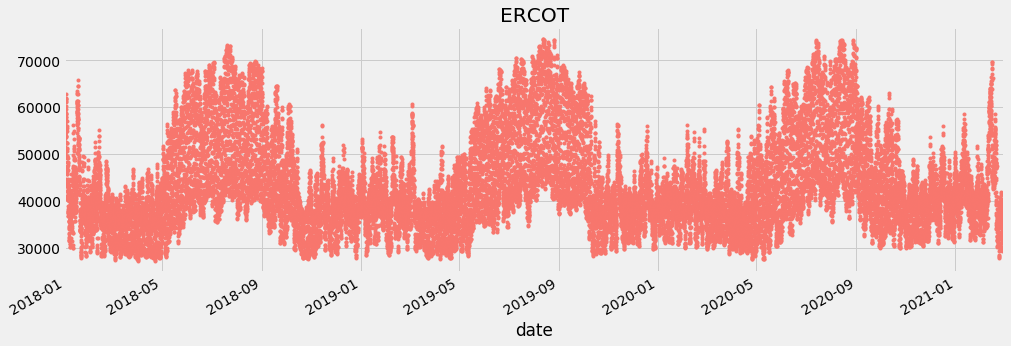

In [20]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

#df.set_index("date", inplace=True)
df["ERCOT"].plot(style='.', figsize=(15,5), color=color_pal[0], title='ERCOT')
plt.show()

In [21]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='ERCOT')

features_and_target = pd.concat([X, y], axis=1)

In [22]:

features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,ERCOT
date,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,1.0,1.0,2018.0,1.0,1.0,1.0,50567.069682
2018-01-01 01:00:00,1.0,0.0,1.0,1.0,2018.0,1.0,1.0,1.0,50617.087977
2018-01-01 02:00:00,2.0,0.0,1.0,1.0,2018.0,1.0,1.0,1.0,50694.300087
2018-01-01 03:00:00,3.0,0.0,1.0,1.0,2018.0,1.0,1.0,1.0,50999.591693
2018-01-01 04:00:00,4.0,0.0,1.0,1.0,2018.0,1.0,1.0,1.0,51723.732017


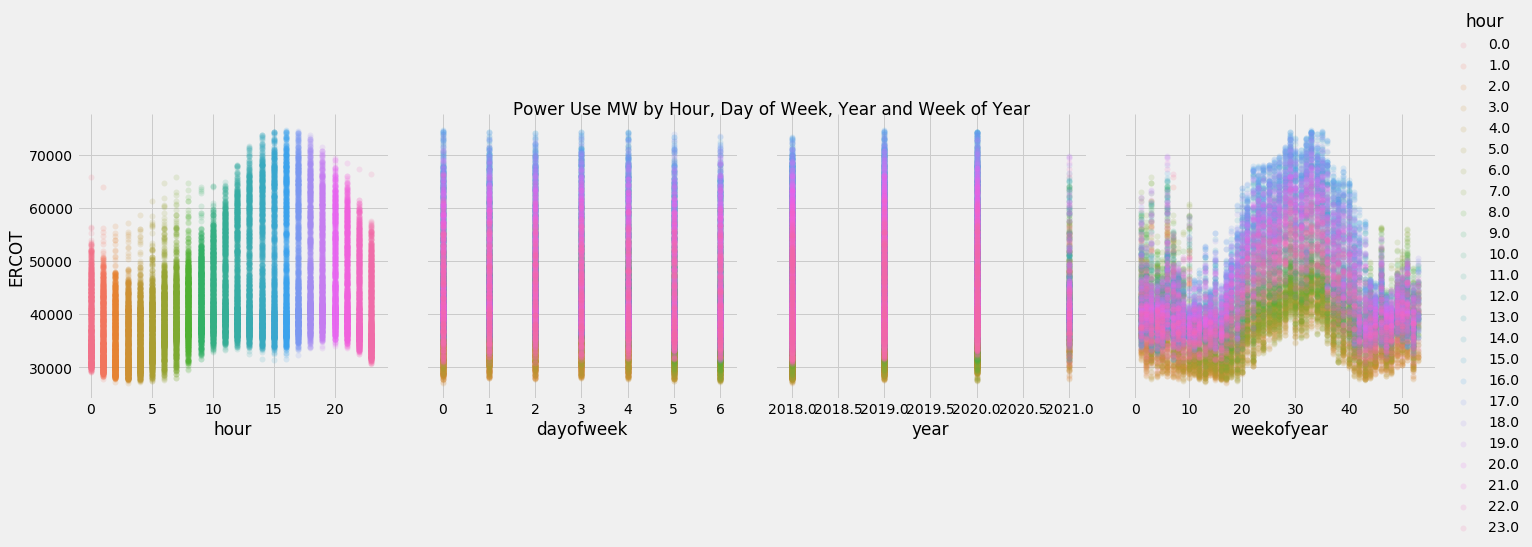

In [33]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='ERCOT',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

In [24]:
split_date = '01-Jan-2021'
pjme = df["ERCOT"]
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [26]:
pjme_train.reset_index() \
    .rename(columns={'date':'ds',
                     'ERCOT':'y'}).head()

,ds,y
0,2018-01-01 00:00:00,50567.069682
1,2018-01-01 01:00:00,50617.087977
2,2018-01-01 02:00:00,50694.300087
3,2018-01-01 03:00:00,50999.591693
4,2018-01-01 04:00:00,51723.732017


In [27]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'date':'ds',
                               'ERCOT':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [28]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'date':'ds'}))

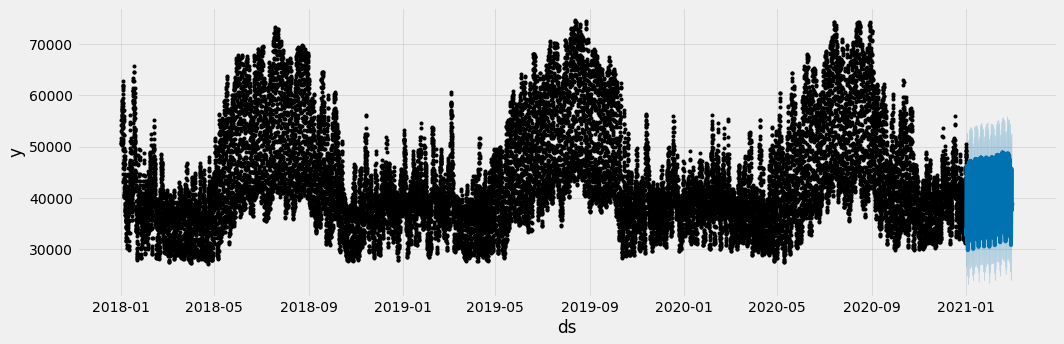

In [29]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

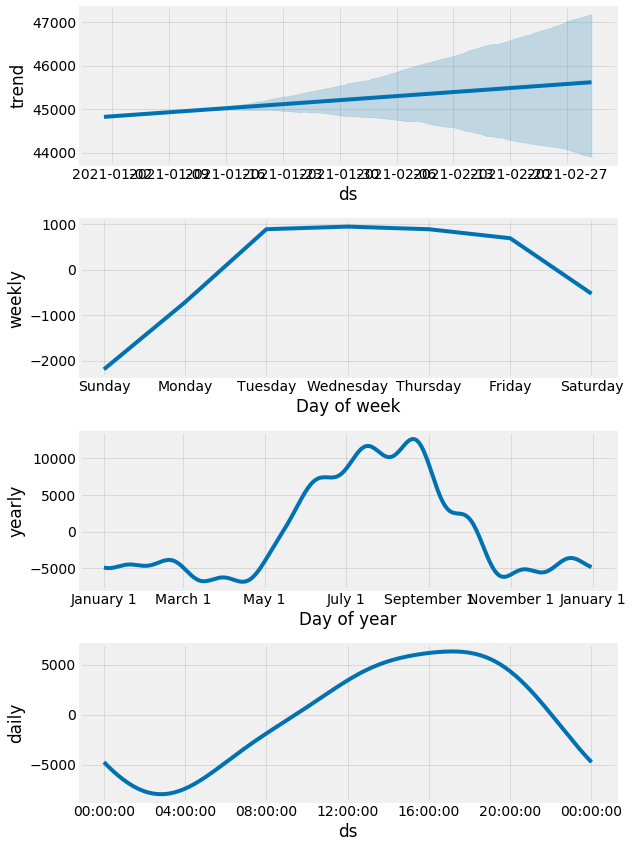

In [30]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

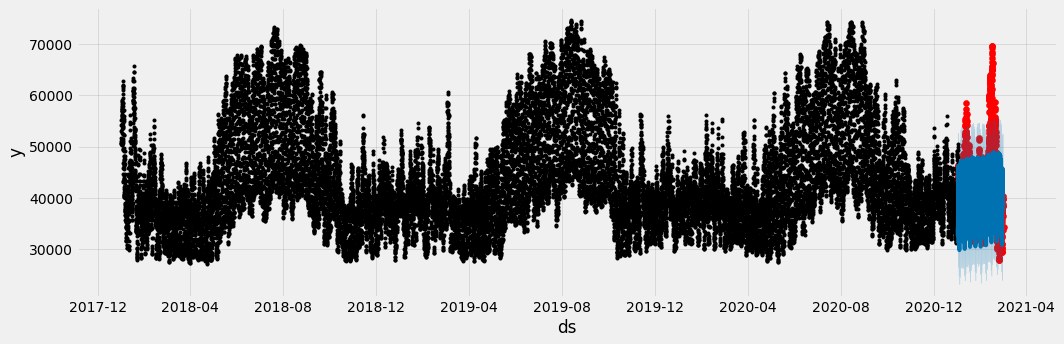

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test, color='r')
fig = model.plot(pjme_test_fcst, ax=ax)